<p align="center">
    <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780081002858000055-f05-13-9780081002858.jpg" width="220" height="240" />

</p>

# Exploratory Data Analysis - Rod Pump Optimization

## Inventors Program Energy - NSC 325

#### Written by: Nicholas Khami, Nashra Ali, Vrishank Jannu

This notebook presents an implementation of a Random Forest Regression to predict the timing of a sucker rod pump failure. The data used for building the following model is provided by ConocoPhillips. The aim of this product is to assist production engineers in hypothesizing a better design for the downhole set-up in order to extend pump lifetimes. Thus, the company can cut yearly maintainence costs (i.e. part replacement) and consequently see an increase oil production per well. This benefits the company in guranteeing a higher return on their investments. 


### Imports

In [46]:
import glob
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Minimal Data Cleaning
To begin approaching the problem, it is important to get a feel for the data that we will be working with. The following code displays the head of the data and dataframe properties. The data documents mechanical and chemical parameters of various wells owned by ConocoPhillips.

In [47]:
rpdf = pd.read_csv("../UT_RodPump_Dataset/rodpump_failure.csv")
rpdf.head()

,roduid,UWI,NODEID,IDWELL,tbguid,lifetime_start,lifetime_end,IDRECJOBPULL,REPORTTO,FAILSTART,...,overall_max_sideload,shallow_max_sideload,max_unguided_sideload,DESANDDEGAS_TYP,CHROME_LENGTH,ENDURALLOY_LENGTH,POLY_LENGTH,NIPPLE_SET_DEPTH,pump_bore,gasanchor_od
0,GB27GKBE51029074693667,175-58-0111,box-child-doctor,GPVO63973435661154,GB55QFGB46756147811400,2014-05-02 00:00:00.000,2019-01-04 10:00:00.000,FGNB86581338411987,Tubing,2018-12-11 00:00:00.000,...,NaN,NaN,NaN,UNKNOWN,0.0,0.00,0.0,10024.8,1.5,NaN
1,GB53OEVX46438297645035,333-68-3523,outside-worry,ZAYT33358197650329,GB29QCCC14341267287129,2018-01-28 14:00:00.000,2019-05-17 12:00:00.000,XRYU81281518151403,Tubing,2019-04-01 00:00:00.000,...,179.44,179.44,179.44,Miller LLC,0.0,0.00,0.0,10235.6,1.5,3.5
2,GB95BPWW35640301552066,165-51-5897,near-learn-simply,FNVL11432909873086,GB02DJAW44801752494129,2011-09-14 00:00:00.000,2012-08-20 00:00:00.000,PLPR44121073149707,Sucker Rod Pump,2012-08-01 00:00:00.000,...,105.76,105.76,105.76,Miller LLC,0.0,0.00,0.0,10401.9,1.5,NaN
3,GB79UEDN31454825972680,543-56-3494,sea-improve-place,JOKL33317998159514,GB84GHPH97287631470412,2016-01-12 09:00:00.000,2017-03-16 16:30:00.000,MYCF04792093856141,Sucker Rod Pump,2017-01-19 00:00:00.000,...,98.18,47.96,98.18,Miller LLC,0.0,0.00,0.0,9557.7,1.75,4.5
4,GB20XCTM13691331349509,391-37-2039,personal-candidate,XOSU92041716672870,GB08VYTX61977431827206,2018-06-14 13:00:00.000,2020-04-15 17:37:11.338,WJDB83445325478746,NaN,NaN,...,266.68,266.68,170.99,Miller LLC,0.0,129.39,0.0,9681.7,1.75,NaN


To begin cleaning, we convert unique well IDs to reformatted integer values and change lifetime_start, lifetime_end, and FAILSTART variables from date objects into integers. We create a new variable "lifetime" to represent the total time a recorded well operates. This will serve as our predictor variable in the regression analysis. We will also at this stage drop rows with too many null values to be useful in training and testing, and will replace any remaining null values with the integer value of 0.

After doing some exploratory data analysis and reviewing summary statsitcs for each feauture, we found the following to be useful for our model: AVG_LIQUID_VOLUME (oil and water), overall_max_sideload, NIPPLE_SET_DEPTH, and all of the average pressures. There were several features such as StrokeLength and Fillage that we thought may be good predictors of failure, but they lacked differentiation throughout the dataframe. 

We think that the features listed are promising because they have differentiation across their quartiles and strong representation throughout the dataframe. Additionally, we hypothesize that they will reflect overall stress on the Rod Pump. 

In [48]:
rpdf = rpdf.dropna(subset=['FAILSTART'], axis=0)
rpdf['UWI'] = rpdf['UWI'].replace('-', '', regex=True).astype(int)

rpdf['lifetime_start'] = pd.to_datetime(rpdf['lifetime_start'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_start'] = rpdf['lifetime_start'].astype(int)

rpdf['lifetime_end'] = pd.to_datetime(rpdf['lifetime_end'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['lifetime_end'] = rpdf['lifetime_end'].astype(int)

rpdf['FAILSTART'] = pd.to_datetime(rpdf['FAILSTART'], format="%Y-%m-%d %H:%M:%S.%f")
rpdf['FAILSTART'] = rpdf['FAILSTART'].astype(int)

rpdf['pump_bore'].replace(to_replace="Other", value=0, inplace=True)
rpdf['pump_bore'] = rpdf['pump_bore'].astype(float)

rpdf['lifetime'] = rpdf['lifetime_end'] - rpdf['lifetime_start']

rpdf.drop(['GrossStrokeLength', 'YesterdaysAverageSPM', 'shallow_max_sideload', 'max_unguided_sideload', 'CHROME_LENGTH', 'ENDURALLOY_LENGTH', 'POLY_LENGTH', 'gasanchor_od', 'chemgroup3_all', 'REPORTTO'], axis=1, inplace=True)

Next, we assign an integer to each unique value for non-numeric columns of data (i.e. represented as integers or floats), known as label encoding. Any remaining null or incomprehensible (inf) values are replaced with the integer "0."

In [49]:
labelencoder = LabelEncoder()
rpdf_cleaned = rpdf.copy()

rpdf_cleaned['roduid'] = labelencoder.fit_transform(rpdf_cleaned['roduid'])
rpdf_cleaned['IDWELL'] = labelencoder.fit_transform(rpdf_cleaned['IDWELL'])
rpdf_cleaned['tbguid'] = labelencoder.fit_transform(rpdf_cleaned['tbguid'])
rpdf_cleaned['IDRECJOBPULL'] = labelencoder.fit_transform(rpdf_cleaned['IDRECJOBPULL'])
rpdf_cleaned['FAILURETYPE'] = labelencoder.fit_transform(rpdf_cleaned['FAILURETYPE'])
rpdf_cleaned['bha_configuration'] = labelencoder.fit_transform(rpdf_cleaned['bha_configuration'])
rpdf_cleaned['wellbore_category'] = labelencoder.fit_transform(rpdf_cleaned['wellbore_category'])
rpdf_cleaned['manual_scale'] = labelencoder.fit_transform(rpdf_cleaned['manual_scale'])
rpdf_cleaned['packer_vs_tac'] = labelencoder.fit_transform(rpdf_cleaned['packer_vs_tac'])
rpdf_cleaned['rod_has_guides'] = labelencoder.fit_transform(rpdf_cleaned['rod_has_guides'])
rpdf_cleaned['rod_make'] = labelencoder.fit_transform(rpdf_cleaned['rod_make'])
rpdf_cleaned['rod_apigrade'] = labelencoder.fit_transform(rpdf_cleaned['rod_apigrade'])
rpdf_cleaned['DESANDDEGAS_TYP'] = labelencoder.fit_transform(rpdf_cleaned['DESANDDEGAS_TYP'])
rpdf_cleaned['rod_sinker_type'] = labelencoder.fit_transform(rpdf_cleaned['rod_sinker_type'])
rpdf_cleaned['NODEID'] = labelencoder.fit_transform(rpdf_cleaned['NODEID'])

rpdf_cleaned.fillna(0, inplace=True)
rpdf_cleaned.replace([np.inf, -np.inf], 0, inplace=True)  

# # we should do feature imputation at this stage

We now assign a training and test set from the data. It is important that the training and test sets do not have any common data rows as this could affect the accuracy of our model.

In [50]:

X = rpdf_cleaned.drop(['FAILSTART', 'lifetime_start', 'lifetime_end', 'lifetime'], axis=1)
y = rpdf_cleaned['lifetime']

#split the data again into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

Here we create random forest regressor object and pass our training set to it. We display the weights of each predictor variable in relation to their correlation with pump lifespan.

Feature: roduid, Score: 0.01769
Feature: UWI, Score: 0.02935
Feature: NODEID, Score: 0.01638
Feature: IDWELL, Score: 0.02429
Feature: tbguid, Score: 0.03270
Feature: IDRECJOBPULL, Score: 0.02078
Feature: FAILURETYPE, Score: 0.00899
Feature: H2S_CONCENTRATION, Score: 0.00280
Feature: PrimarySetpoint, Score: 0.00981
Feature: SecondarySetpoint, Score: 0.03521
Feature: StrokeLength, Score: 0.01240
Feature: Fillage, Score: 0.02465
Feature: bha_configuration, Score: 0.01532
Feature: chemgroup1_any, Score: 0.03524
Feature: chemgroup1_all, Score: 0.01803
Feature: chemgroup2_any, Score: 0.06462
Feature: chemgroup2_all, Score: 0.05362
Feature: chemgroup3_any, Score: 0.00161
Feature: max_unguided_dls, Score: 0.02151
Feature: dls_high_in_hole, Score: 0.01644
Feature: gas_anchor_length, Score: 0.03932
Feature: MAX_INCLINATION, Score: 0.02213
Feature: wellbore_category, Score: 0.00442
Feature: manual_scale, Score: 0.00260
Feature: packer_vs_tac, Score: 0.01252
Feature: AVG_PRESS_FLOWLINE, Score: 0.0

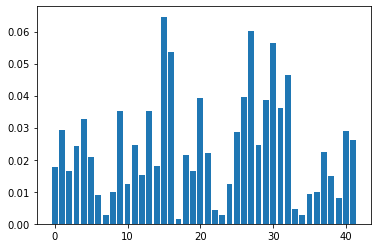

In [71]:
reg = RandomForestRegressor(bootstrap = True, max_depth = None, max_features = 'log2', n_estimators = 13)
reg.fit(X_train, y_train)
feature_names = list(X_train.columns)

importance = reg.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [52]:
param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'], 'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}
rfr = RandomForestRegressor(random_state = 35)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)
g_search.fit(X_train, y_train)
print(g_search.best_params_)

{'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 13}


In [64]:
g_search.best_score_

0.42325356489524824

In [66]:
rfr_random_reg = RandomForestRegressor(random_state = 35)
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt', 'log2'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
r_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
print(r_grid)

{'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]}


In [67]:
rfr_random = RandomizedSearchCV(estimator=rfr_random_reg, param_distributions=r_grid, n_iter = 20, scoring='neg_mean_absolute_error', cv = 3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)
rfr_random.fit(X_train, y_train)
print(rfr_random.best_score_)
print(rfr_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
-1.876059615577698e+16
{'n_estimators': 11, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [56]:
print(rfr_random.score(X_test , y_test))

-1.7956514365770638e+16


In [74]:
#score it up
reg.score(X_test, y_test)

0.3202999908169646

In [77]:
# #and export so we can visualize what is going on
for k in range(12):
   dot_data = tree.export_graphviz(reg.estimators_[k+1], out_file='reggraph_' + str((k+1)), feature_names=X.columns, filled=True)
# tree.plot_tree(reg.estimators_[1])